In [1]:
from pathlib import Path
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics

In [2]:
#data_base = Path("shared/NSD")
data_base = Path("/home/jovyan/shared/NSD")
curr_subj = "subj01"
subj_behav_file = data_base / f"nsddata/ppdata/{curr_subj}/behav/responses.tsv"
subj_behav = pd.read_csv(subj_behav_file, delimiter="\t")

In [3]:
# add within session iteration indices
for sess_id in range(1, 37+1):
    subj_behav.loc[subj_behav["SESSION"]==sess_id, "INSESSIONIDX"] = list(range(1, 750+1))
    

subj_behav_sel = subj_behav.dropna(subset=["BUTTON"])
subj_behav_sel = subj_behav_sel[~subj_behav_sel["SESSION"].isin([38, 39, 40])]
#print(len(subj_behav_sel))
print(subj_behav_sel.index)


Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            27740, 27741, 27742, 27743, 27744, 27745, 27746, 27747, 27748,
            27749],
           dtype='int64', length=27739)


In [5]:


# take the first saved data
betas = np.load("./nsd-data/MTL-1_full.npy")

print(betas.shape)



(27750, 345)


In [6]:


X = betas[subj_behav_sel.index, :] / 300
y = subj_behav_sel["ISOLDCURRENT"].to_numpy()

print(X.shape)

(27739, 345)


# The code above for dataset loading can be reused directly for 1D-CNN.

In [7]:
X = X.reshape(X.shape[0], -1)
print(X.shape) # flattened version

(27739, 345)


In [8]:


from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report



In [9]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [10]:


svc = LinearSVC(class_weight="balanced", verbose=10)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)



[LibLinear]....................................................................................................
optimization finished, #iter = 1000

Using -s 2 may be faster (also see FAQ)

Objective value = -1179.304383
nSV = 18543


In [11]:


conf_mat = confusion_matrix(y_test, y_pred)
conf_mat



array([[5235, 1761],
       [1537,  621]])

In [12]:
classification_report(y_test, y_pred, output_dict=True)

{'0': {'precision': 0.7730360307147076,
  'recall': 0.7482847341337907,
  'f1-score': 0.760459035444509,
  'support': 6996},
 '1': {'precision': 0.2607052896725441,
  'recall': 0.28776645041705284,
  'f1-score': 0.273568281938326,
  'support': 2158},
 'accuracy': 0.6397203408346078,
 'macro avg': {'precision': 0.5168706601936258,
  'recall': 0.5180255922754218,
  'f1-score': 0.5170136586914175,
  'support': 9154},
 'weighted avg': {'precision': 0.6522571647360109,
  'recall': 0.6397203408346078,
  'f1-score': 0.6456774922867262,
  'support': 9154}}

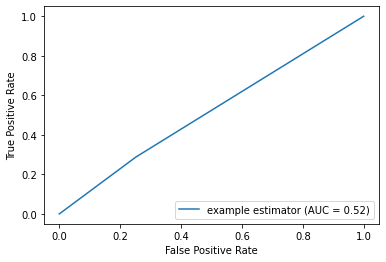

In [13]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()